In [ ]:
# MacOS 사용시 
import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"Mac GPU(MPS) 사용 가능: {torch.backends.mps.is_available()}")

PyTorch 버전: 2.9.1
Mac GPU(MPS) 사용 가능: True


In [2]:
# ===== 라이브러리 불러오기 =====
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 랜덤 시드 고정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 한글 폰트 설정 (MacOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# LINUX 서버 사용시 폰트 
# import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 


### 1단계 : 데이터 로딩 및 기본 탐색
- gimi9-geocoder를 활용하여 아파트 위도(y)/경도(x) 좌표 획득 
    - 지오코더 API를 활용하여 위도/경도 좌표 획득하기 위해 위선 Train과 Test 데이터셋에서 addr.csv 추출 
    - get_xy.ipynb로 데이터 획득 : addr_xy.csv

In [3]:
# 데이터 파일 읽기
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
addr_xy_df = pd.read_csv("data/addr_xy.csv")
bus_df = pd.read_csv("data/bus_feature.csv")
subway_df = pd.read_csv("data/subway_feature.csv")

In [5]:
# Target 변수 분포 확인
print(f"\nTarget 변수 기본 통계 (단위: 만원)")
print(f" - 최소값: {train_df['target'].min():,.0f}")
print(f" - 최대값: {train_df['target'].max():,.0f}")
print(f" - 평균값: {train_df['target'].mean():,.0f}")
print(f" - 중앙값: {train_df['target'].median():,.0f}")
print(f" - 표준편차: {train_df['target'].std():,.0f}")


Target 변수 기본 통계 (단위: 만원)
 - 최소값: 350
 - 최대값: 1,450,000
 - 평균값: 57,992
 - 중앙값: 44,800
 - 표준편차: 46,426


 - 왜도(Skewness): 3.5176 (양수 = 오른쪽 꼬리가 긴 분포)


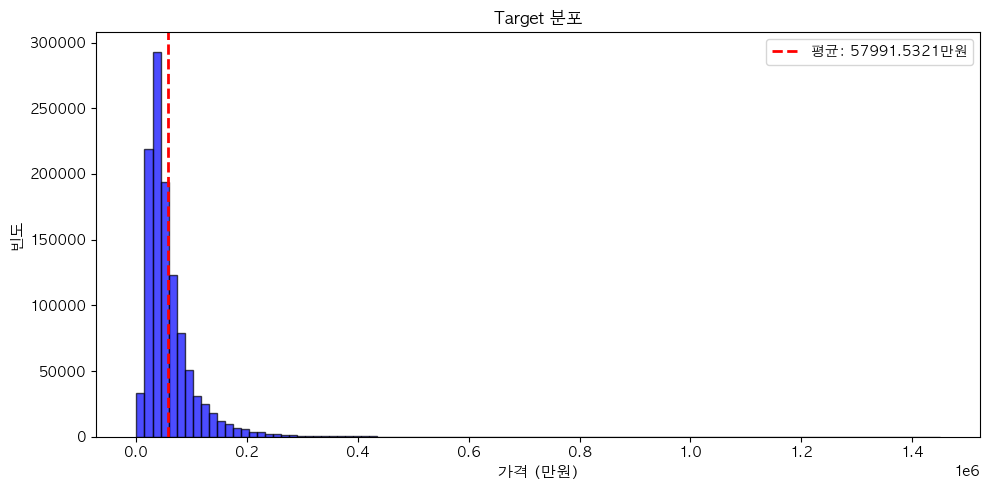

In [6]:
# Target 분포 확인 (왜도)
from scipy import stats
skewness = stats.skew(train_df['target'])
print(f" - 왜도(Skewness): {skewness:.4f} (양수 = 오른쪽 꼬리가 긴 분포)")

plt.figure(figsize=(10, 5))

plt.hist(train_df['target'], bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('가격 (만원)', fontsize=11)
plt.ylabel('빈도', fontsize=11)
plt.title('Target 분포', fontsize=12, fontweight='bold')
plt.axvline(train_df['target'].mean(), color='red', linestyle='--', linewidth=2, label=f"평균: {train_df['target'].mean():.4f}만원")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Target 로그 변환 (Right Skewness 완화 : np.log1p 적용)

target_original = train_df['target'].copy()

train_df['target'] = np.log1p(train_df['target'])
skewness_after = stats.skew(train_df['target'])
print(f" - 로그 변환 후 왜도: {skewness_after:.4f}")
print(f" - 왜도 감소: {skewness:.4f} → {skewness_after:.4f}")

 - 로그 변환 후 왜도: 0.2813
 - 왜도 감소: 3.5176 → 0.2813


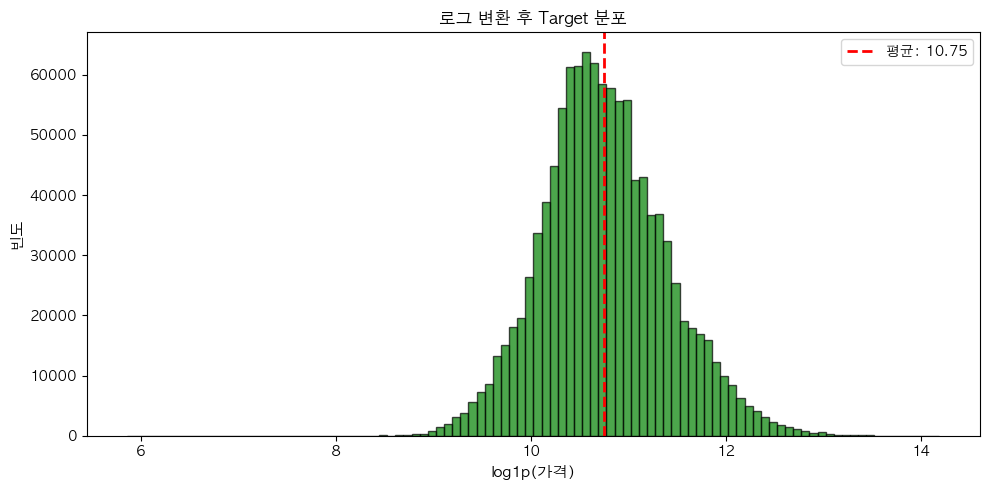

In [8]:
plt.figure(figsize=(10, 5))

plt.hist(train_df['target'], bins=100, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('log1p(가격)', fontsize=11)
plt.ylabel('빈도', fontsize=11)
plt.title('로그 변환 후 Target 분포', fontsize=12, fontweight='bold')
plt.axvline(train_df['target'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f"평균: {train_df['target'].mean():.2f}")
plt.legend()
plt.tight_layout()
plt.show()

### 2단계: 이상치 제거 (Train 데이터만)
- 조건 1: '층' <= 0 인 행 삭제
- 조건 2: 'target' <= log1p(10,000) 이하 AND '전용면적(㎡)' >= 60 인 행 삭제

In [9]:
# 조건 1: 층 <= 0 인 데이터
print(f" - 층 <= 0: {len(train_df[train_df['층'] <= 0])}개\n")
print(train_df[train_df['층'] <= 0])


 - 층 <= 0: 261개

                   시군구        번지     본번      부번       아파트명  전용면적(㎡)    계약년월  \
26438    서울특별시 구로구 천왕동       280  280.0     0.0  천왕연지타운1단지    84.95  201805   
51467    서울특별시 마포구 대흥동     18-55   18.0    55.0         성신    75.06  201808   
68371    서울특별시 성북구 장위동   230-214  230.0   214.0        신장위    84.81  201803   
86730    서울특별시 용산구 이촌동     193-3  193.0     3.0         강변    64.43  201801   
87307    서울특별시 용산구 한남동       810  810.0     0.0       한남더힐   240.23  201804   
...                ...       ...    ...     ...        ...      ...     ...   
1115746   서울특별시 중구 신당동  432-1982  432.0  1982.0         다다    59.95  200708   
1115815   서울특별시 중구 신당동  432-2000  432.0  2000.0      스위스빌라    38.53  200705   
1115827   서울특별시 중구 신당동  432-1972  432.0  1972.0         신신    53.88  200701   
1115831   서울특별시 중구 신당동  432-1957  432.0  1957.0         신신    59.04  200709   
1115924   서울특별시 중구 신당동  432-1061  432.0  1061.0       토토타워    59.94  200709   

         계약일  층  건축년도  ...      건축

In [10]:
# 조건 2: 전용면적 >= 60 이고 target <= log1p(10000) 인 데이터
print(f" - 전용면적 >= 60㎡ AND target <= log1p(10,000): {len(train_df[(train_df['전용면적(㎡)'] >= 60) & (train_df['target'] <= np.log1p(10000))])}개\n")
print(train_df[(train_df['전용면적(㎡)'] >= 60) & (train_df['target'] <= np.log1p(10000))])

 - 전용면적 >= 60㎡ AND target <= log1p(10,000): 156개

                   시군구      번지      본번    부번        아파트명  전용면적(㎡)    계약년월  \
89668    서울특별시 은평구 신사동   226-5   226.0   5.0         뉴월드    69.86  201802   
99297    서울특별시 강남구 일원동   690-2   690.0   2.0        현대사원    61.21  201111   
99360    서울특별시 강남구 청담동      14    14.0   0.0  청담2차이-편한세상   113.21  201111   
108326    서울특별시 구로구 궁동   178-7   178.0   7.0       대명하이빌    83.10  201201   
109009   서울특별시 금천구 시흥동    1008  1008.0   0.0          금강    84.65  201206   
...                ...     ...     ...   ...         ...      ...     ...   
1114989  서울특별시 은평구 역촌동   62-16    62.0  16.0         무궁화    61.97  200704   
1114990  서울특별시 은평구 역촌동   62-16    62.0  16.0         무궁화    63.43  200705   
1115572  서울특별시 종로구 통인동     5-1     5.0   1.0          효자    61.49  200708   
1116001   서울특별시 중구 중림동     149   149.0   0.0         성요셉    68.00  200703   
1116908   서울특별시 중랑구 묵동  177-12   177.0  12.0         리치빌    69.44  200704   

         계약일  층  건축년도  ..

In [11]:
original_train_len = len(train_df)

# 조건 1: '층' <= 0 인 행 삭제
if '층' in train_df.columns:
    before = len(train_df)
    train_df = train_df[train_df['층'] > 0].reset_index(drop=True)
    removed = before - len(train_df)
    print(f" 조건 1: '층' <= 0 인 행 삭제 → {removed:,}개 행 제거")

# 조건 2: 'target' <= log1p(10,000) 이하 AND '전용면적(㎡)' >= 60 인 행 삭제
if '전용면적(㎡)' in train_df.columns:
    before = len(train_df)
    threshold = np.log1p(10000)  # target이 로그 변환되어 있으므로
    condition = (train_df['target'] <= threshold) & (train_df['전용면적(㎡)'] >= 60)
    train_df = train_df[~condition].reset_index(drop=True)
    removed = before - len(train_df)
    print(f" 조건 2: target <= log1p(10,000) AND 전용면적 >= 60㎡ 인 행 삭제 → {removed:,}개 행 제거")


 조건 1: '층' <= 0 인 행 삭제 → 261개 행 제거
 조건 2: target <= log1p(10,000) AND 전용면적 >= 60㎡ 인 행 삭제 → 154개 행 제거


### 3단계: Train/Test 합치기 및 변수명 정리
- **데이터 누수 방지를 위하여 target 제외**

In [12]:
# test_yn 컬럼 추가
train_df['test_yn'] = 0
test_df['test_yn'] = 1

# target 분리 저장
y_train = train_df['target'].copy()
train_df = train_df.drop('target', axis=1)

# 데이터 합치기 (데이터 누수를 방지하기 위하여 target 제외)
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print(f" 합친 데이터: {full_df.shape[0]:,}행 x {full_df.shape[1]:,}열")


 합친 데이터: 1,127,679행 x 52열


In [13]:
# 변수명 정리 (특수기호 제거)
rename_dict = {
    '전용면적(㎡)': '전용면적',
    'k-전용면적별세대현황(60㎡이하)': 'k-전용면적(60이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)': 'k-전용면적(60~85이하)',
    'k-85㎡~135㎡이하': 'k-전용면적(85~135이하)',
    'k-135㎡초과': 'k-전용면적(135이상)'
}

# 실제 존재하는 컬럼만 rename
rename_dict_exist = {k: v for k, v in rename_dict.items() if k in full_df.columns}
full_df = full_df.rename(columns=rename_dict_exist)
print(f" 변수명 정리: {len(rename_dict_exist)}개 컬럼 이름 변경")
for old, new in rename_dict_exist.items():
    print(f"   - '{old}' → '{new}'")

 변수명 정리: 5개 컬럼 이름 변경
   - '전용면적(㎡)' → '전용면적'
   - 'k-전용면적별세대현황(60㎡이하)' → 'k-전용면적(60이하)'
   - 'k-전용면적별세대현황(60㎡~85㎡이하)' → 'k-전용면적(60~85이하)'
   - 'k-85㎡~135㎡이하' → 'k-전용면적(85~135이하)'
   - 'k-135㎡초과' → 'k-전용면적(135이상)'


### 4단계: 좌표 결측치 보완
- 지오코더를 통해 획득한 x,y 좌표를 데이터셋에 반영

In [14]:
# 좌표 결측치 확인
if '좌표X' in full_df.columns and '좌표Y' in full_df.columns:
    missing_coords = full_df['좌표X'].isnull() | full_df['좌표Y'].isnull()
    print(f"좌표 결측치: {missing_coords.sum():,}개")
    
    if missing_coords.sum() > 0:
        # addr_xy_df에서 주소 기준으로 매핑
        # addr_xy.csv는 시군구, 본번, 부번으로 구성되어 있음 (이파일은 get_xy.ipynb로 생성)
        if '시군구' in full_df.columns and '본번' in full_df.columns and '부번' in full_df.columns:
            # full_df에서 주소 키 생성 (float → int → str)
            full_df['주소_key'] = (
                full_df['시군구'].astype(str) + '_' + 
                full_df['본번'].fillna(-999).astype(int).astype(str) + '_' + 
                full_df['부번'].fillna(-999).astype(int).astype(str)
            )
            
            # addr_xy_df도 동일하게 주소 키 생성 (int → str)
            if '시군구' in addr_xy_df.columns and '본번' in addr_xy_df.columns and '부번' in addr_xy_df.columns:
                addr_xy_df['주소_key'] = (
                    addr_xy_df['시군구'].astype(str) + '_' + 
                    addr_xy_df['본번'].fillna(-999).astype(int).astype(str) + '_' + 
                    addr_xy_df['부번'].fillna(-999).astype(int).astype(str)
                )
                
                # 딕셔너리로 변환 (first : 중복 주소는 첫 번째 좌표 사용)
                addr_to_xy = addr_xy_df.groupby('주소_key').agg({'좌표X': 'first', '좌표Y': 'first'}).to_dict()
                
                # 결측치가 있는 곳만 채우기
                filled_count = 0
                for idx in full_df[missing_coords].index:
                    addr_key = full_df.loc[idx, '주소_key']
                    if addr_key in addr_to_xy['좌표X']:
                        full_df.loc[idx, '좌표X'] = addr_to_xy['좌표X'][addr_key]
                        full_df.loc[idx, '좌표Y'] = addr_to_xy['좌표Y'][addr_key]
                        filled_count += 1
                
                print(f" {filled_count:,}개 좌표 결측치 보완 완료")
                
                # 임시 컬럼 제거
                full_df = full_df.drop('주소_key', axis=1)
            else:
                print(" addr_xy.csv에 필요한 컬럼이 없습니다 (시군구, 본번, 부번)")
        else:
            print(" full_df에 필요한 컬럼이 없습니다 (시군구, 본번, 부번)")
        
        # 여전히 남은 결측치 확인
        missing_coords_after = full_df['좌표X'].isnull() | full_df['좌표Y'].isnull()
        print(f" - 남은 좌표 결측치: {missing_coords_after.sum():,}개")

좌표 결측치: 875,857개
 875,782개 좌표 결측치 보완 완료
 - 남은 좌표 결측치: 75개


### 5단계: 결측치 처리
- 5-1. 의미 없는 데이터로 채워진 컬럼 삭제
- 5-2. 결측치 1,000,000개 이상인 컬럼 삭제
- 5-3. 변수 타입 수정
- 5-4. 범주형/연속형 변수 결측치 보간  

In [15]:
# 5-1. 의미 없는 데이터로 채워진 컬럼 삭제

meaningless_cols = ['등기신청일자', '거래유형', '중개사소재지']
meaningless_cols_exist = [col for col in meaningless_cols if col in full_df.columns]
if meaningless_cols_exist:
    full_df = full_df.drop(meaningless_cols_exist, axis=1)
    print(f" {len(meaningless_cols_exist)}개 컬럼 삭제: {meaningless_cols_exist}")
else:
    print(" 해당 컬럼 없음")

 3개 컬럼 삭제: ['등기신청일자', '거래유형', '중개사소재지']


In [16]:
# 5-2. 결측치 1,000,000개 이상인 컬럼 삭제

missing_counts = full_df.isnull().sum()
high_missing_cols = missing_counts[missing_counts >= 1000000].index.tolist()
if high_missing_cols:
    full_df = full_df.drop(high_missing_cols, axis=1)
    print(f" {len(high_missing_cols)}개 컬럼 삭제")
    for col in high_missing_cols:
        print(f"   - {col}: {missing_counts[col]:,}개")
else:
    print(" 해당 컬럼 없음")

 5개 컬럼 삭제
   - 해제사유발생일: 1,121,490개
   - 단지소개기존clob: 1,058,550개
   - k-전용면적(135이상): 1,127,350개
   - k-홈페이지: 1,013,110개
   - k-등록일자: 1,115,971개


In [17]:
# 5-3. 변수 타입 수정

for col in ['본번', '부번']:
    if col in full_df.columns:
        # 문자열로 변환
        full_df[col] = full_df[col].astype(str)
        print(f" '{col}': 정수 → 문자열 변환")

 '본번': 정수 → 문자열 변환
 '부번': 정수 → 문자열 변환


In [18]:
# 5-4. 범주형/연속형 변수 결측치 보간

# 좌표는 반드시 숫자형으로 유지
if '좌표X' in full_df.columns:
    full_df['좌표X'] = pd.to_numeric(full_df['좌표X'], errors='coerce')
if '좌표Y' in full_df.columns:
    full_df['좌표Y'] = pd.to_numeric(full_df['좌표Y'], errors='coerce')

# 범주형 변수: 'NULL'로 채우기
categorical_cols = full_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if full_df[col].isnull().sum() > 0:
        full_df[col] = full_df[col].fillna('NULL')

print(f" 범주형 변수 {len(categorical_cols)}개: 'NULL'로 채움")

# 연속형 변수: 선형 보간 + 중앙값
numeric_cols = full_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if full_df[col].isnull().sum() > 0:
        # 선형 보간
        full_df[col] = full_df[col].interpolate(method='linear', limit_direction='both')
        # 남은 결측치는 중앙값으로
        if full_df[col].isnull().sum() > 0:
            full_df[col] = full_df[col].fillna(full_df[col].median())

print(f" 연속형 변수 {len(numeric_cols)}개: 선형보간 + 중앙값")

 범주형 변수 26개: 'NULL'로 채움
 연속형 변수 18개: 선형보간 + 중앙값


In [19]:
# 최종 결측치 확인
remaining_nulls = full_df.isnull().sum().sum()
print(f" - 남은 결측치: {remaining_nulls:,}개")

 - 남은 결측치: 0개


### 6단계: 파생변수 생성
- 6-1. 지역 변수
- 6-2. 시간 변수 (아파트 나이)
- 6-3. 재건축/리모델링 여부
- 6-4. 면적 변수
- 6-5. 단지 변수
- 6-6. 층고 변수
- 6-7. 역세권 변수 (Haversine 공식 - 벡터화)
- 6-8. 시차 변수 (구/동별 그룹화)  

In [20]:
# 6-1. 지역 변수

if '시군구' in full_df.columns:
    # '구'와 '동' 분리
    full_df['구'] = full_df['시군구'].str.split().str[-1]
    # 시군구에서 '구' 앞부분을 '동'으로 추출
    full_df['동'] = full_df['시군구'].str.split().str[:-1].str.join(' ')

In [21]:
# 6-2. 시간 변수

if '계약년월' in full_df.columns:
    full_df['계약년'] = full_df['계약년월'] // 100
    full_df['계약월'] = full_df['계약년월'] % 100
    print(f" '계약년', '계약월' 분리")

if '건축년도' in full_df.columns and '계약년' in full_df.columns:
    full_df['아파트나이'] = full_df['계약년'] - full_df['건축년도']
    full_df['아파트나이'] = full_df['아파트나이'].clip(lower=0)  # 음수 방지
    print(f" '아파트나이' 생성 (음수 방지)")
    
    # 신축 여부 (10년 이내)
    full_df['신축'] = (full_df['아파트나이'] <= 10).astype(str)
    print(f" '신축' 여부: 10년 이내(1) / 아님(0)")
    
    # 노후 여부 (30년 이상)
    full_df['노후'] = (full_df['아파트나이'] >= 30).astype(str)
    print(f" '노후' 여부: 30년 이상(1) / 아님(0)")

 '계약년', '계약월' 분리
 '아파트나이' 생성 (음수 방지)
 '신축' 여부: 10년 이내(1) / 아님(0)
 '노후' 여부: 30년 이상(1) / 아님(0)


In [22]:
# 6-3. 재건축/리모델링 여부

if 'k-시행사' in full_df.columns:
    keywords = ['재건축', '리모델링']
    full_df['재건축리모델링'] = full_df['k-시행사'].str.contains(
        '|'.join(keywords), case=False, na=False
    ).astype(str)
    print(f" '재건축리모델링' 여부 생성")

 '재건축리모델링' 여부 생성


In [23]:
# 6-3. 면적 변수
# 중형 아파트의 평당 가격이 가장 높기 때문에 중형 아파트의 가격을 기준으로 면적 변수 생성

if '전용면적' in full_df.columns:
    # 평형 구간
    full_df['평형'] = pd.cut(
        full_df['전용면적'],
        bins=[0, 60, 85, 135, 1000],
        labels=['소형', '중형', '중대형', '대형']
    )
    print(f" '평형' 구간: 소형(<60㎡), 중형(60~85㎡), 중대형(85~135㎡), 대형(135㎡~)")

 '평형' 구간: 소형(<60㎡), 중형(60~85㎡), 중대형(85~135㎡), 대형(135㎡~)


In [24]:
# 6-4. 단지 변수
# 아파트 브랜드와 대단지 여부, 주상복합 여부에 따라 가격차 발생 

if 'k-전체세대수' in full_df.columns:
    full_df['대단지'] = (full_df['k-전체세대수'] >= 500).astype(str)
    print(f" '대단지' 여부: 500세대 이상(1) / 아님(0)")

if '아파트명' in full_df.columns:
    brand_keywords = ['래미안', '힐스테이트', '자이', 'e편한세상', '푸르지오', '아이파크', 
                     '더샵', '롯데캐슬', '디에이치', '센트럴', '파크', '트리', '포레']
    full_df['브랜드아파트'] = full_df['아파트명'].str.contains(
        '|'.join(brand_keywords), case=False, na=False
    ).astype(str)
    print(f" '브랜드아파트' 여부 생성")
    
    # 주상복합
    full_df['주상복합'] = full_df['아파트명'].str.contains('주상복합', case=False, na=False).astype(str)
    print(f" '주상복합' 여부 생성")


 '대단지' 여부: 500세대 이상(1) / 아님(0)
 '브랜드아파트' 여부 생성
 '주상복합' 여부 생성


In [25]:
# 6-5. 층고 변수
# 로얄층 여부에 따라 가격차 발생 

if '층' in full_df.columns:
    def classify_floor(floor):
        if floor <= 5:
            return '저층'
        elif floor <= 15:
            return '중층'
        else:
            return '고층'
    
    full_df['층고구간'] = full_df['층'].apply(classify_floor)
    print(f" '층고구간': 저층(≤5층), 중층(6~15층), 고층(≥16층)")

 '층고구간': 저층(≤5층), 중층(6~15층), 고층(≥16층)


In [26]:
# 6-6. 역세권 변수 (Haversine 공식 - 벡터화)
# 역세권 여부에 따라 가격차 발생 

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """벡터화된 Haversine 거리 계산 (km)"""
    R = 6371  # 지구 반지름 (km)
    
    # 라디안 변환
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine 공식
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [27]:
# 지하철역 변수
# 500m 이내 지하철역 수에 따라 가격차 발생 
# 500m 이내 버스정류소 수를 고려하여 교통편의성 점수를 반영 

if '좌표X' in full_df.columns and '좌표Y' in full_df.columns:
    # 좌표를 명시적으로 숫자형으로 변환
    full_df['좌표X'] = pd.to_numeric(full_df['좌표X'], errors='coerce')
    full_df['좌표Y'] = pd.to_numeric(full_df['좌표Y'], errors='coerce')
    
    subway_coords = subway_df[['경도', '위도']].values
    apt_lons = full_df['좌표X'].values
    apt_lats = full_df['좌표Y'].values
    
    subway_count_500m = np.zeros(len(full_df), dtype=int)
    
    # 배치 처리
    batch_size = 5000
    n_batches = int(np.ceil(len(full_df) / batch_size))
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(full_df))
        
        if (batch_idx + 1) % 10 == 0:
            print(f"   지하철 계산 진행: {batch_idx+1}/{n_batches} 배치")
        
        batch_lons = apt_lons[start_idx:end_idx]
        batch_lats = apt_lats[start_idx:end_idx]
        
        valid_mask = ~(np.isnan(batch_lons) | np.isnan(batch_lats))
        valid_indices = np.where(valid_mask)[0]
        
        if len(valid_indices) == 0:
            continue
        
        valid_lons = batch_lons[valid_indices]
        valid_lats = batch_lats[valid_indices]
        
        for i, (apt_lon, apt_lat) in enumerate(zip(valid_lons, valid_lats)):
            distances = haversine_vectorized(
                apt_lat, apt_lon,
                subway_coords[:, 1], subway_coords[:, 0]
            )
            global_idx = start_idx + valid_indices[i]
            subway_count_500m[global_idx] = np.sum(distances <= 0.5)
    
    full_df['지하철역수_500m'] = subway_count_500m
    full_df['역세권여부'] = (full_df['지하철역수_500m'] >= 1).astype(str)
    print(f" 지하철역 변수 생성 완료")
    
    # 버스 정류소 변수
    bus_coords = bus_df[['X좌표', 'Y좌표']].values
    bus_count_500m = np.zeros(len(full_df), dtype=int)
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(full_df))
        
        if (batch_idx + 1) % 10 == 0:
            print(f"   버스 계산 진행: {batch_idx+1}/{n_batches} 배치")
        
        batch_lons = apt_lons[start_idx:end_idx]
        batch_lats = apt_lats[start_idx:end_idx]
        
        valid_mask = ~(np.isnan(batch_lons) | np.isnan(batch_lats))
        valid_indices = np.where(valid_mask)[0]
        
        if len(valid_indices) == 0:
            continue
        
        valid_lons = batch_lons[valid_indices]
        valid_lats = batch_lats[valid_indices]
        
        for i, (apt_lon, apt_lat) in enumerate(zip(valid_lons, valid_lats)):
            distances = haversine_vectorized(
                apt_lat, apt_lon,
                bus_coords[:, 1], bus_coords[:, 0]
            )
            global_idx = start_idx + valid_indices[i]
            bus_count_500m[global_idx] = np.sum(distances <= 0.5)
    
    full_df['버스정류소수_500m'] = bus_count_500m
    print(f" 버스 정류소 변수 생성 완료")
    
    # 교통편의성 점수
    full_df['교통편의성점수'] = (
        full_df['지하철역수_500m'] * 3 + 
        full_df['버스정류소수_500m'] * 0.5
    )
    print(f" '교통편의성점수' 생성")

   지하철 계산 진행: 10/226 배치
   지하철 계산 진행: 20/226 배치
   지하철 계산 진행: 30/226 배치
   지하철 계산 진행: 40/226 배치
   지하철 계산 진행: 50/226 배치
   지하철 계산 진행: 60/226 배치
   지하철 계산 진행: 70/226 배치
   지하철 계산 진행: 80/226 배치
   지하철 계산 진행: 90/226 배치
   지하철 계산 진행: 100/226 배치
   지하철 계산 진행: 110/226 배치
   지하철 계산 진행: 120/226 배치
   지하철 계산 진행: 130/226 배치
   지하철 계산 진행: 140/226 배치
   지하철 계산 진행: 150/226 배치
   지하철 계산 진행: 160/226 배치
   지하철 계산 진행: 170/226 배치
   지하철 계산 진행: 180/226 배치
   지하철 계산 진행: 190/226 배치
   지하철 계산 진행: 200/226 배치
   지하철 계산 진행: 210/226 배치
   지하철 계산 진행: 220/226 배치
 지하철역 변수 생성 완료
   버스 계산 진행: 10/226 배치
   버스 계산 진행: 20/226 배치
   버스 계산 진행: 30/226 배치
   버스 계산 진행: 40/226 배치
   버스 계산 진행: 50/226 배치
   버스 계산 진행: 60/226 배치
   버스 계산 진행: 70/226 배치
   버스 계산 진행: 80/226 배치
   버스 계산 진행: 90/226 배치
   버스 계산 진행: 100/226 배치
   버스 계산 진행: 110/226 배치
   버스 계산 진행: 120/226 배치
   버스 계산 진행: 130/226 배치
   버스 계산 진행: 140/226 배치
   버스 계산 진행: 150/226 배치
   버스 계산 진행: 160/226 배치
   버스 계산 진행: 170/226 배치
   버스 계산 진행: 180/226 배치
   버스 계산 진행: 190/226 

In [28]:
# 6-7. 시차 변수 (구/동별 그룹화)
if '구' in full_df.columns and '동' in full_df.columns and '계약년월' in full_df.columns:
    # test_yn으로 분리하여 train에만 target 추가
    temp_df = full_df.copy()
    temp_df['target'] = np.nan
    
    # train 부분에만 target 추가
    train_mask = temp_df['test_yn'] == 0
    temp_df.loc[train_mask, 'target'] = y_train.values
    
    # 계약년월 기준 정렬
    temp_df = temp_df.sort_values(['구', '동', '계약년월']).reset_index(drop=True)
    
    # price_lag_1, 2, 3: 1~3개월 전 평균 가격
    for lag in [1, 2, 3]:
        temp_df[f'price_lag_{lag}'] = temp_df.groupby(['구', '동'])['target'].shift(lag)
    
    # price_rolling_mean_3: 최근 3개월 이동평균
    temp_df['price_rolling_mean_3'] = temp_df.groupby(['구', '동'])['target'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )
    
    # nearby_region_avg: 구별 평균 가격
    region_avg = temp_df.groupby('구')['target'].transform('mean')
    temp_df['nearby_region_avg'] = region_avg
    
    # 원래 인덱스로 복원
    temp_df = temp_df.sort_index()
    
    # full_df에 시차 변수 추가
    for col in ['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_rolling_mean_3', 'nearby_region_avg']:
        full_df[col] = temp_df[col].values

### 7단계: 불필요한 변수 삭제
- 파생변수 생성에 따른 원본 변수 삭제 포함 

In [30]:
full_df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적(60이하)', 'k-전용면적(60~85이하)', 'k-전용면적(85~135이하)', 'k-수정일자',
       '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'test_yn', '구', '동', '계약년', '계약월', '아파트나이', '신축', '노후',
       '재건축리모델링', '평형', '대단지', '브랜드아파트', '주상복합', '층고구간', '지하철역수_500m', '역세권여부',
       '버스정류소수_500m', '교통편의성점수', 'price_lag_1', 'price_lag_2', 'price_lag_3',
       'price_rolling_mean_3', 'nearby_region_avg'],
      dtype='object')

In [31]:
drop_cols = [
    '시군구', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 
    'k-세대타입(분양형태)', 'k-관리방식', 'k-사용검사일-사용승인일', 
    'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', 
    '경비비관리형태', '세대전기계약방법', '청소비관리형태', 
    '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', 
    '관리비 업로드', '단지신청일',
    # 추가 삭제 대상 (중복 또는 불필요)
    '본번', '부번', '번지', '도로명', '해제사유발생일', '계약일',
    # 상관관계 히트맵 확인 후 추가 삭제 대상
    '계약년월', 'k-전용면적(60이하)', 'k-전용면적(60~85이하)', 'k-전용면적(85~135이하)', 
    'k-주거전용면적', 'K-관리비부과면적', 'k-전체동수'
]

# 실제 존재하는 컬럼만 삭제
drop_cols_exist = [col for col in drop_cols if col in full_df.columns]
full_df = full_df.drop(drop_cols_exist, axis=1)

print(f" {len(drop_cols_exist)}개 변수 삭제 완료")
print(f" - 남은 변수 개수: {full_df.shape[1]}개")

 27개 변수 삭제 완료
 - 남은 변수 개수: 39개


In [32]:
full_df.columns

Index(['아파트명', '전용면적', '층', '건축년도', 'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-난방방식',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-관리비부과면적', '건축면적', '주차대수',
       '좌표X', '좌표Y', 'test_yn', '구', '동', '계약년', '계약월', '아파트나이', '신축', '노후',
       '재건축리모델링', '평형', '대단지', '브랜드아파트', '주상복합', '층고구간', '지하철역수_500m', '역세권여부',
       '버스정류소수_500m', '교통편의성점수', 'price_lag_1', 'price_lag_2', 'price_lag_3',
       'price_rolling_mean_3', 'nearby_region_avg'],
      dtype='object')

### 8단계: 상관관계 분석 및 시각화 

In [33]:
# Train 데이터만 분리 (상관관계 분석용)
train_mask = full_df['test_yn'] == 0
train_for_corr = full_df[train_mask].copy()
train_for_corr = train_for_corr.drop('test_yn', axis=1)
train_for_corr['target'] = y_train.values

# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in train_for_corr.columns:
    if pd.api.types.is_numeric_dtype(train_for_corr[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체세대수', 'k-연면적', 'k-관리비부과면적', '건축면적', '주차대수', '좌표X', '좌표Y', '계약년', '계약월', '아파트나이', '지하철역수_500m', '버스정류소수_500m', '교통편의성점수', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_rolling_mean_3', 'nearby_region_avg', 'target']
범주형 변수: ['아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', '구', '동', '신축', '노후', '재건축리모델링', '평형', '대단지', '브랜드아파트', '주상복합', '층고구간', '역세권여부']


    1. 전용면적                          : 0.6278
    2. 계약년                           : 0.3987
    3. 좌표Y                           : 0.3440
    4. k-연면적                         : 0.2201
    5. k-관리비부과면적                     : 0.1967
    6. 주차대수                          : 0.1942
    7. 층                             : 0.1621
    8. 버스정류소수_500m                   : 0.1595
    9. k-전체세대수                       : 0.1353
   10. 지하철역수_500m                    : 0.1058
   11. 좌표X                           : 0.1018
   12. 교통편의성점수                       : 0.0960
   13. 아파트나이                         : 0.0887
   14. 건축년도                          : 0.0878
   15. 계약월                           : 0.0554
   16. nearby_region_avg             : 0.0479
   17. price_rolling_mean_3          : 0.0319
   18. price_lag_3                   : 0.0299
   19. price_lag_1                   : 0.0298
   20. price_lag_2                   : 0.0296
   21. 건축면적                          : 0.0014


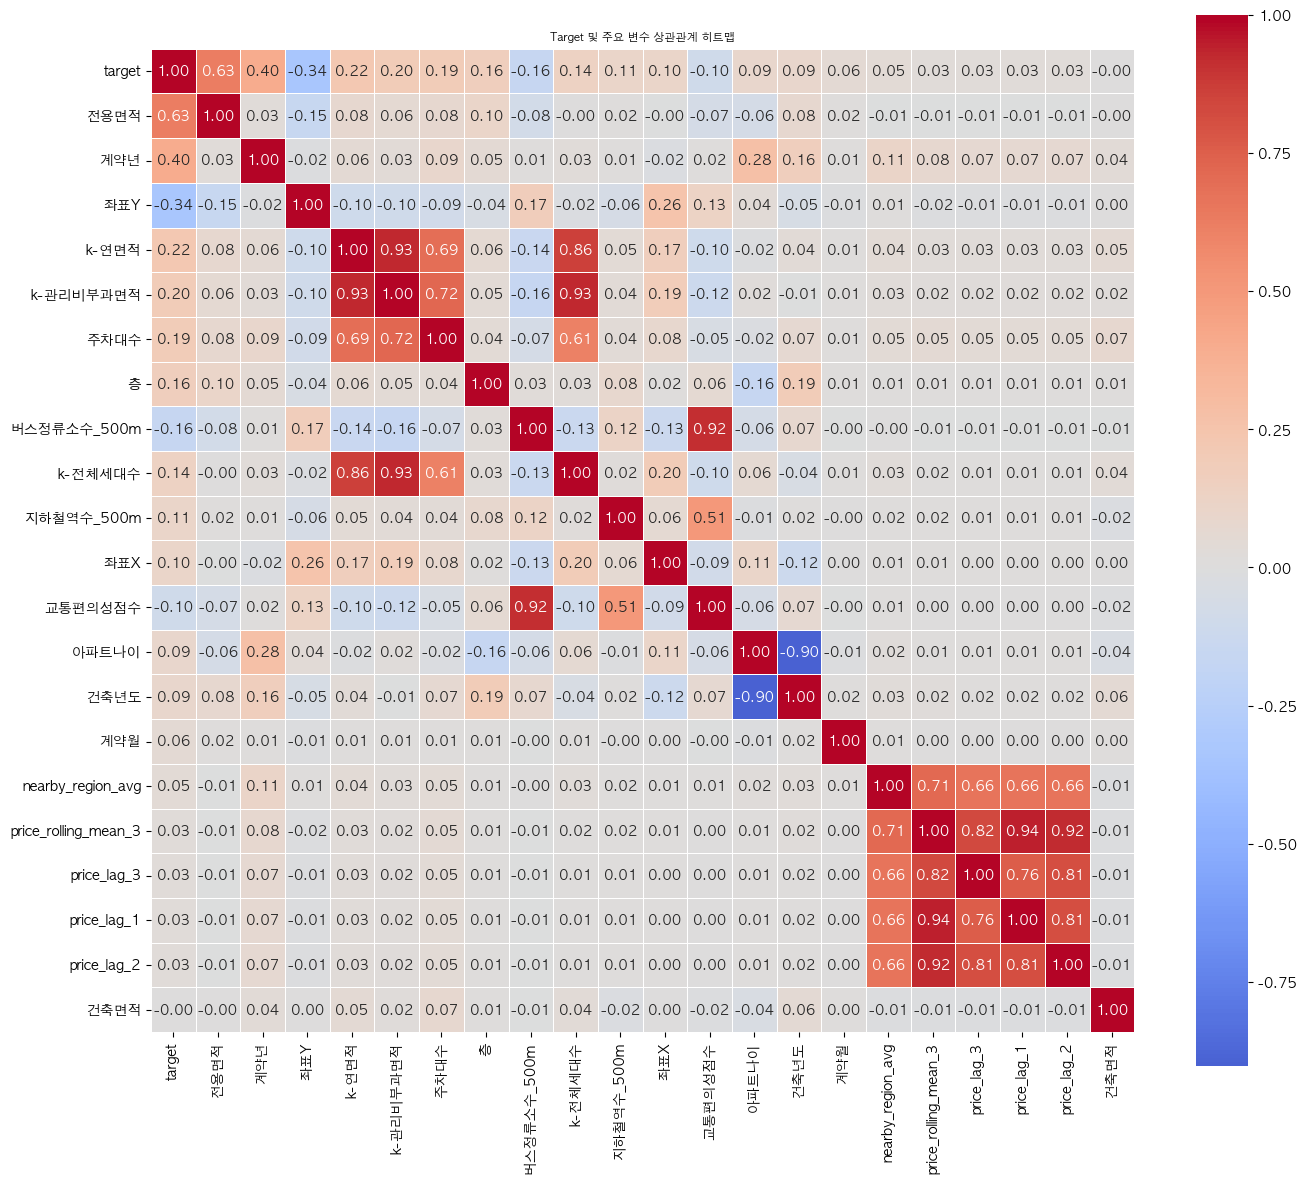

In [34]:
# target과의 상관계수 계산
correlations = train_for_corr[continuous_columns_v2].corr()['target'].abs().sort_values(ascending=False)

numerical_features = correlations[1:]  # target 자신 제외
for idx, (feature, corr) in enumerate(numerical_features.items(), 1):
    print(f"   {idx:2d}. {feature:30s}: {corr:.4f}")

# 상관계수 히트맵 생성
plt.figure(figsize=(14, 12))
top_features = correlations.index.tolist()  # target 포함
corr_matrix = train_for_corr[top_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Target 및 주요 변수 상관관계 히트맵', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.show()

### 9단계: Train/Test 분리
- Lebel Encodig : 성능에 오히려 도움이 안됨 

In [35]:
# test_yn 기준 분리
train_processed = full_df[full_df['test_yn'] == 0].copy()
test_processed = full_df[full_df['test_yn'] == 1].copy()

# test_yn 컬럼 삭제
train_processed = train_processed.drop('test_yn', axis=1)
test_processed = test_processed.drop('test_yn', axis=1)

# Train에 target 추가 (로그 변환된 상태)
train_processed['target'] = y_train.values

print(f" 학습 데이터: {train_processed.shape[0]:,}행 x {train_processed.shape[1]}열 (target 포함)")
print(f" 테스트 데이터: {test_processed.shape[0]:,}행 x {test_processed.shape[1]}열")

 학습 데이터: 1,118,407행 x 39열 (target 포함)
 테스트 데이터: 9,272행 x 38열


In [36]:
# # 범주형 변수들을 대상으로 레이블인코딩 : 성능에 도움이 안됨 
# # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
# from tqdm import tqdm

# label_encoders = {}

# # Implement Label Encoding
# for col in tqdm(categorical_columns_v2):
#     lbl = LabelEncoder()

#     # Label-Encoding을 fit
#     lbl.fit(
#         train_processed[col].astype(str)
#     )
#     train_processed[col] = lbl.transform(train_processed[col].astype(str))
#     label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

#     # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
#     for label in np.unique(test_processed[col]):
#       if label not in lbl.classes_: # unseen label 데이터인 경우
#         lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

#     test_processed[col] = lbl.transform(test_processed[col].astype(str))

In [37]:
train_processed.head(3)  

,아파트명,전용면적,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-복도유형,k-난방방식,k-전체세대수,k-건설사(시공사),k-시행사,...,지하철역수_500m,역세권여부,버스정류소수_500m,교통편의성점수,price_lag_1,price_lag_2,price_lag_3,price_rolling_mean_3,nearby_region_avg,target
0,개포6차우성,79.97,3,1987,아파트,계단식,개별난방,270.0,우성건설,모름,...,0,False,13,6.5,NaN,NaN,NaN,10.825780,11.001797,11.728045
1,개포6차우성,79.97,4,1987,아파트,계단식,개별난방,270.0,우성건설,모름,...,0,False,13,6.5,10.82578,NaN,NaN,10.819780,11.001797,11.724005
2,개포6차우성,54.98,5,1987,아파트,계단식,개별난방,270.0,우성건설,모름,...,0,False,13,6.5,10.81378,10.82578,NaN,10.816436,11.001797,11.424105


In [38]:
train_processed.shape[1] == test_processed.shape[1] + 1          # train/test dataset의 shape이 같은지 확인해주겠습니다.

True

- Time Series 문제는 학습과 검증 데이터를 랜덤하게 8:2로 나누는 것은 적절치 않은 것으로 판단됨

In [ ]:
# # Train을 8:2로 나누어 검증 데이터 생성 : 단순히 8:2로 검증하는 것은 좋지 않은 사례 - 학습 데이터 보다 미래의 가격을 예측하는 것이므로
# from sklearn.model_selection import train_test_split

# # Target과 독립변수들을 분리해줍니다.
# y_train = train_processed['target']
# X_train = train_processed.drop(['target'], axis=1)

# # Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### 10단계: AutoGluon 모델 학습 

In [ ]:
# # AutoGluon 모델을 사용하여 학습을 시키기 위하여 DataFrame으로 재결합
# train_final = pd.concat([X_train, y_train], axis=1)
# val_final = pd.concat([X_val, y_val], axis=1)

# print(f"학습 데이터: {len(train_final):,}개")
# print(f"검증 데이터: {len(val_final):,}개")

학습 데이터: 894,725개
검증 데이터: 223,682개


In [40]:
# AutoGluon 학습 
try:
    predictor = TabularPredictor(
        label='target',
        eval_metric='root_mean_squared_error',  # RMSE로 학습 (대회 평가 기준)
        path='./autogluon_medium_quality'
    ).fit(
        train_processed,      # 학습(Train) 데이터
        # train_data=train_final,      # 학습(Train) 데이터
        # tuning_data=val_final,       # 검증(Validation) 데이터
        time_limit=3600,
        presets='medium_quality',

        # ===== 메모리 설정 =====
        ag_args_fit={
            'ag.max_memory_usage_ratio': 1.5,  # 메모리 75% 사용 
            'num_cpus': 12,
            'num_gpus': 1
        },
        verbosity=2
    )
    
    print("\n모델 학습 완료!")
    
except Exception as e:
    print(f"\n오류 발생: {e}")
    exit(1)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:09:56 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T6041
CPU Count:          12
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       7.70 GB / 24.00 GB (32.1%)
Disk Space Avail:   396.55 GB / 460.43 GB (86.1%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/Users/owy007/dev/apt_regression/autogluon_medium_quality"
Train Data Rows:    1118407
Train Data Columns: 38
Label Column:       target
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column =

[1000]	valid_set's rmse: 0.0973064
[2000]	valid_set's rmse: 0.0866179
[3000]	valid_set's rmse: 0.081357
[4000]	valid_set's rmse: 0.0782924
[5000]	valid_set's rmse: 0.0762527
[6000]	valid_set's rmse: 0.0746497
[7000]	valid_set's rmse: 0.0734477
[8000]	valid_set's rmse: 0.0725149
[9000]	valid_set's rmse: 0.0718109
[10000]	valid_set's rmse: 0.071172


	-0.0712	 = Validation score   (-root_mean_squared_error)
	176.86s	 = Training   runtime
	1.41s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 3417.19s of the 3417.19s of remaining time.
	Fitting with cpus=12, gpus=0, mem=1.1/7.6 GB


[1000]	valid_set's rmse: 0.0795741
[2000]	valid_set's rmse: 0.0734769
[3000]	valid_set's rmse: 0.0710978
[4000]	valid_set's rmse: 0.069768
[5000]	valid_set's rmse: 0.068911
[6000]	valid_set's rmse: 0.068375
[7000]	valid_set's rmse: 0.0678589
[8000]	valid_set's rmse: 0.0675004
[9000]	valid_set's rmse: 0.0672137
[10000]	valid_set's rmse: 0.0669693


	-0.067	 = Validation score   (-root_mean_squared_error)
	185.75s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 3230.27s of the 3230.27s of remaining time.
	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.42 to avoid the error)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
	Not enough memory to train RandomForestMSE... Skipping this model.
Fitting model: CatBoost ... Training model for up to 3229.86s of the 3229.86s of remaining time.
	Fitting with cpus=12, gpus=0, mem=1.5/8.6 GB
	-0.0772	 = Validation score   (-root_mean_squared_error)
	2072.24s	 = Training   runti


모델 학습 완료!


### 10-1단계: Permutation Importance 기반 변수 선택

In [41]:
try:
    # AutoGluon의 feature_importance는 permutation importance 사용
    feature_importance_df = predictor.feature_importance(train_processed)
    
    # DataFrame인 경우 평균 계산
    if isinstance(feature_importance_df, pd.DataFrame):
        if len(feature_importance_df.columns) > 1:
            feature_importance_series = feature_importance_df.mean(axis=1)
        else:
            feature_importance_series = feature_importance_df.iloc[:, 0]
    else:
        feature_importance_series = feature_importance_df
    
    # 절대값 기준 정렬
    feature_importance_series = feature_importance_series.abs().sort_values(ascending=False)
    
    print("\nPermutation Importance 상위 20개 변수:")
    top_20_features = feature_importance_series.head(20)
    for idx, (feature, score) in enumerate(top_20_features.items(), 1):
        print(f"   {idx:2d}. {feature:35s}: {score:.6f}")
    
    # 중요도가 거의 0인 변수 찾기 (임계값: 0.5)
    low_importance_threshold = 0.5
    low_importance_features = feature_importance_series[feature_importance_series.abs() < low_importance_threshold]
    
    print(f"\n중요도가 매우 낮은 변수 ({low_importance_threshold} 미만): {len(low_importance_features)}개")
    if len(low_importance_features) > 0:
        print(f" - 변수 목록 (상위 20개만 표시):")
        for idx, (feature, score) in enumerate(low_importance_features.head(20).items(), 1):
            print(f"     {idx:2d}. {feature:35s}: {score:.6f}")
    else:
        print("모든 변수가 어느 정도 중요도를 가지고 있습니다")
    
    # 변수 중요도를 파일로 저장
    feature_importance_series.to_csv('feature_importance_scores.csv', header=['importance'])
    print(f"\n변수 중요도 저장: feature_importance_scores.csv")
    
except Exception as e:
    print(f"Permutation Importance 계산 중 오류: {e}")
    print(" - 계속 진행합니다...")

Computing feature importance via permutation shuffling for 38 features using 5000 rows with 5 shuffle sets...
	115.72s	= Expected runtime (23.14s per shuffle set)
	129.66s	= Actual runtime (Completed 5 of 5 shuffle sets)



Permutation Importance 상위 20개 변수:
    1. 전용면적                               : 1.047510
    2. 계약년                                : 1.007265
    3. 구                                  : 0.914465
    4. 좌표Y                                : 0.892978
    5. 아파트명                               : 0.879962
    6. 동                                  : 0.875203
    7. 건축년도                               : 0.867215
    8. 좌표X                                : 0.866489
    9. 계약월                                : 0.846569
   10. 브랜드아파트                             : 0.844814
   11. 층                                  : 0.840937
   12. 아파트나이                              : 0.840686
   13. 버스정류소수_500m                        : 0.838981
   14. price_lag_1                        : 0.838413
   15. 교통편의성점수                            : 0.837250
   16. price_rolling_mean_3               : 0.836178
   17. 지하철역수_500m                         : 0.835942
   18. k-연면적                              : 0.835613
   19. pric

### 11-1. 단계: 모델 평가 및 시각화

In [42]:
# 리더보드 확인
leaderboard = predictor.leaderboard(silent=True)
print("\n모델 성능 리더보드 (상위 10개):")
print(leaderboard.head(10).to_string())

best_model_name = leaderboard.iloc[0]['model']
best_score = leaderboard.iloc[0]['score_val']

print(f"\n최고 성능 모델: {best_model_name} 검증 RMSE: {abs(best_score):.4f} (로그 스케일)")

# 학습 데이터로 예측 (평가용)
train_predictions = predictor.predict(train_processed)
actual_prices_log = train_processed['target']

# 로그 스케일에서 성능 지표 계산
mae_log = mean_absolute_error(actual_prices_log, train_predictions)
rmse_log = np.sqrt(mean_squared_error(actual_prices_log, train_predictions))
r2_log = r2_score(actual_prices_log, train_predictions)

print(f"\n학습 데이터 성능 지표 (로그 스케일):")
print(f" - MAE:  {mae_log:.4f}, RMSE: {rmse_log:.4f}(학습/평가 지표), R²: {r2_log:.4f}")

# 원래 스케일로 역변환하여 성능 지표 계산
actual_prices_original = np.expm1(actual_prices_log)
predictions_original = np.expm1(train_predictions)

mae_original = mean_absolute_error(actual_prices_original, predictions_original)
rmse_original = np.sqrt(mean_squared_error(actual_prices_original, predictions_original))
r2_original = r2_score(actual_prices_original, predictions_original)

print(f"\n학습 데이터 성능 지표 (원본 스케일, 단위: 만원):")
print(f" - MAE:  {mae_original:,.2f}만원, RMSE: {rmse_original:,.2f}만원, R²: {r2_original:.4f}")

# # 검증 데이터로 예측
# val_predictions = predictor.predict(X_val)
# actual_val_log = y_val

# # 로그 스케일 성능
# val_mae_log = mean_absolute_error(actual_val_log, val_predictions)
# val_rmse_log = np.sqrt(mean_squared_error(actual_val_log, val_predictions))
# val_r2_log = r2_score(actual_val_log, val_predictions)

# # 원본 스케일 성능
# actual_val_original = np.expm1(actual_val_log)
# val_predictions_original = np.expm1(val_predictions)

# val_mae_original = mean_absolute_error(actual_val_original, val_predictions_original)
# val_rmse_original = np.sqrt(mean_squared_error(actual_val_original, val_predictions_original))
# val_r2_original = r2_score(actual_val_original, val_predictions_original)

# print(f"\n검증 데이터 성능 지표 (원본 스케일, 단위: 만원):")
# print(f" - MAE:  {val_mae_original:,.2f}만원, RMSE: {val_rmse_original:,.2f}만원, R²: {val_r2_original:.4f}")

# # 학습 vs 검증 비교
# print("\n                  학습      vs     검증 성능 비교")
# print(f"{'RMSE (로그)':<15} {rmse_log:<20.4f} {val_rmse_log:<20.4f} {val_rmse_log - rmse_log:+<15.4f}")
# print(f"{'RMSE (만원)':<15} {rmse_original:<20,.2f} {val_rmse_original:<20,.2f} {val_rmse_original - rmse_original:+<15,.2f}")
# print(f"{'R²':<15} {r2_original:<20.4f} {val_r2_original:<20.4f} {val_r2_original - r2_original:+<15.4f}")

# # 과적합 체크
# overfitting_ratio = val_rmse_log / rmse_log
# if overfitting_ratio > 1.1:
#     print(f"\n경고: 검증/학습 비율 = {overfitting_ratio:.3f} (>1.1) → 과적합 가능성!")
# elif overfitting_ratio > 1.05:
#     print(f"\n검증/학습 비율 = {overfitting_ratio:.3f} (1.05~1.1) → 정상 범위")
# else:
#     print(f"\n검증/학습 비율 = {overfitting_ratio:.3f} (<1.05) → 과적합 없음!")




모델 성능 리더보드 (상위 10개):
                 model  score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2  -0.063946  root_mean_squared_error       1.040579   995.811873                0.000158           0.006969            2       True          7
1             LightGBM  -0.066969  root_mean_squared_error       0.754492   185.745151                0.754492         185.745151            1       True          2
2              XGBoost  -0.067898  root_mean_squared_error       0.248702   192.143657                0.248702         192.143657            1       True          5
3      NeuralNetFastAI  -0.069335  root_mean_squared_error       0.037227   617.916096                0.037227         617.916096            1       True          4
4           LightGBMXT  -0.071172  root_mean_squared_error       1.409270   176.856440                1.409270         176.856440            1       True

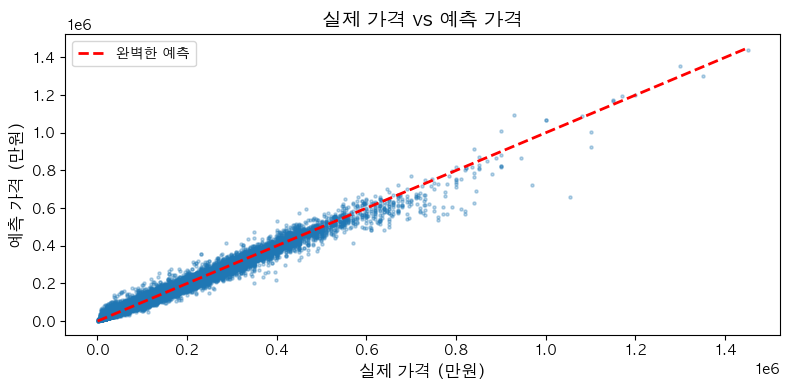

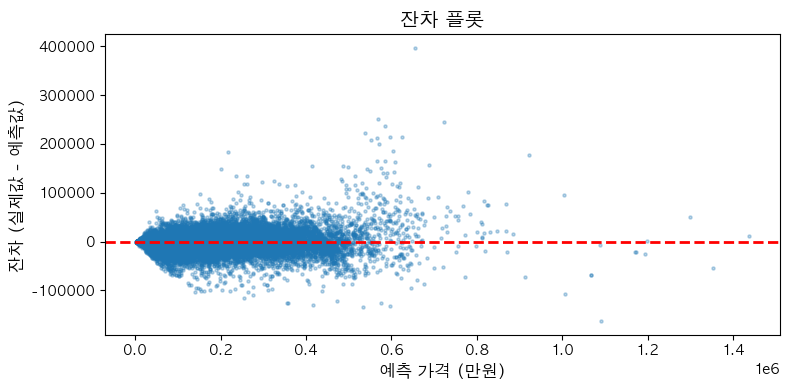

Computing feature importance via permutation shuffling for 38 features using 5000 rows with 5 shuffle sets...
	117.89s	= Expected runtime (23.58s per shuffle set)
	121.76s	= Actual runtime (Completed 5 of 5 shuffle sets)



상위 20개 중요 변수:
    1. 전용면적                          : 1.0475
    2. 계약년                           : 1.0073
    3. 구                             : 0.9145
    4. 좌표Y                           : 0.8930
    5. 아파트명                          : 0.8800
    6. 동                             : 0.8752
    7. 건축년도                          : 0.8672
    8. 좌표X                           : 0.8665
    9. 계약월                           : 0.8466
   10. 브랜드아파트                        : 0.8448
   11. 층                             : 0.8409
   12. 아파트나이                         : 0.8407
   13. 버스정류소수_500m                   : 0.8390
   14. price_lag_1                   : 0.8384
   15. 교통편의성점수                       : 0.8373
   16. price_rolling_mean_3          : 0.8362
   17. 지하철역수_500m                    : 0.8359
   18. k-연면적                         : 0.8356
   19. price_lag_2                   : 0.8354
   20. k-관리비부과면적                     : 0.8353


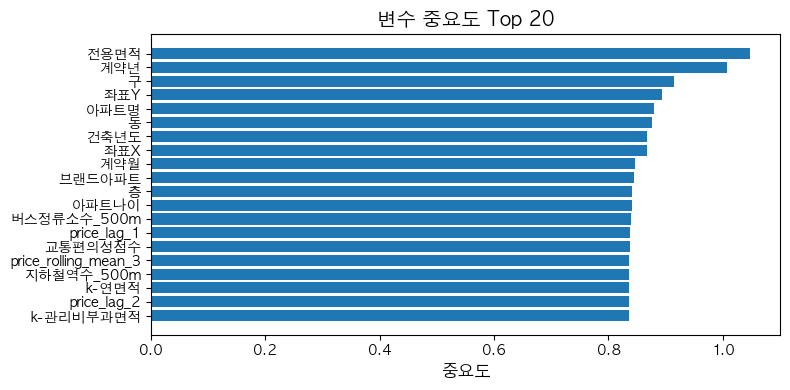

In [43]:
# 시각화 생성
# 1. 실제값 vs 예측값 산점도
plt.figure(figsize=(8, 4))
plt.scatter(actual_prices_original, predictions_original, alpha=0.3, s=5)
plt.plot([actual_prices_original.min(), actual_prices_original.max()], 
         [actual_prices_original.min(), actual_prices_original.max()], 
         'r--', linewidth=2, label='완벽한 예측')
plt.xlabel('실제 가격 (만원)', fontsize=12)
plt.ylabel('예측 가격 (만원)', fontsize=12)
plt.title('실제 가격 vs 예측 가격', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# 2. 잔차 플롯
residuals = actual_prices_original - predictions_original
plt.figure(figsize=(8, 4))
plt.scatter(predictions_original, residuals, alpha=0.3, s=5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('예측 가격 (만원)', fontsize=12)
plt.ylabel('잔차 (실제값 - 예측값)', fontsize=12)
plt.title('잔차 플롯', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. 변수 중요도
try:
    feature_importance = predictor.feature_importance(train_processed)
    
    # feature_importance가 DataFrame인 경우 (여러 모델의 중요도)
    if isinstance(feature_importance, pd.DataFrame):
        # 모든 모델의 평균 중요도 사용
        if len(feature_importance.columns) > 1:
            feature_importance = feature_importance.mean(axis=1)
        else:
            # 컬럼이 하나면 Series로 변환
            feature_importance = feature_importance.iloc[:, 0]
    
    # 절대값 기준으로 정렬
    feature_importance = feature_importance.abs().sort_values(ascending=False)
    
    print(f"\n상위 20개 중요 변수:")
    top_features_imp = feature_importance.head(20)
    for idx, (feature, score) in enumerate(top_features_imp.items(), 1):
        print(f"   {idx:2d}. {feature:30s}: {score:.4f}")
     
    # 변수 중요도 시각화
    plt.figure(figsize=(8, 4))
    plt.barh(range(len(top_features_imp)), top_features_imp.values)
    plt.yticks(range(len(top_features_imp)), top_features_imp.index)
    plt.xlabel('중요도', fontsize=12)
    plt.title('변수 중요도 Top 20', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"변수 중요도 분석 중 오류: {e}")

### 12단계: 테스트 예측 및 제출 파일 생성

In [45]:
test_predictions_log = predictor.predict(test_processed)

# 로그 역변환 (원본 스케일로)
test_predictions_original = np.expm1(test_predictions_log)

print(f"\n예측 가격 통계 (단위: 만원):")
print(f" - 최소값: {test_predictions_original.min():,.2f}")
print(f" - 최대값: {test_predictions_original.max():,.2f}")
print(f" - 평균값: {test_predictions_original.mean():,.2f}")
print(f" - 중앙값: {np.median(test_predictions_original):,.2f}")

# 제출 파일 생성 (정수형으로 제출)
submission = pd.DataFrame({
    'target': test_predictions_original.astype(int)
})

# 결측치 및 음수 확인
null_count = submission['target'].isnull().sum()
negative_count = (submission['target'] < 0).sum()

if null_count > 0 or negative_count > 0:
    print(f"\n파일에 오류가 있습니다.")

# 파일 저장
submission_file = 'submission_train_only.csv'
submission.to_csv(submission_file, index=False)



예측 가격 통계 (단위: 만원):
 - 최소값: 8,647.95
 - 최대값: 1,190,945.75
 - 평균값: 107,383.40
 - 중앙값: 88,415.80
